# ELBO Bound

In [1]:
import os

import wandb
import tikzplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow import default_float
from gpflow.likelihoods import Gaussian

from docs.sde.ou.ou_generate_data import generate_data, plot_data, set_seed
from markovflow.sde.sde import PriorOUSDE
from markovflow.models.cvi_sde import SDESSM
from markovflow.models.vi_sde import VariationalMarkovGP
from docs.sde.sde_exp_utils import get_gpr
from markovflow.kernels.matern import OrnsteinUhlenbeck

from docs.sde.t_vgp_trainer import tVGPTrainer

2022-08-29 13:33:24.870274: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 13:33:24.870307: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-29 13:33:27.138237: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-29 13:33:27.139461: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-29 13:33:27.169083: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-29 13:33:27.169151: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: verma
2022-08-29 13:33:27.169173: I tensorflow/stream_execut

In [2]:
set_seed(18)
os.environ['WANDB_MODE'] = 'offline'
wandb.init(project="VI-SDE")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Data

In [3]:
decay     = 2.
q         = .8
x0        = 0.
t0        = 0.
t1        = 2.
noise_var = 0.5
dt        = 0.001
n_obs     = 10

In [4]:
obs_vals, obs_grid, latent_p, time_grid, _, _  = generate_data(decay, q, x0, t0, t1, noise_var, dt, n_obs)

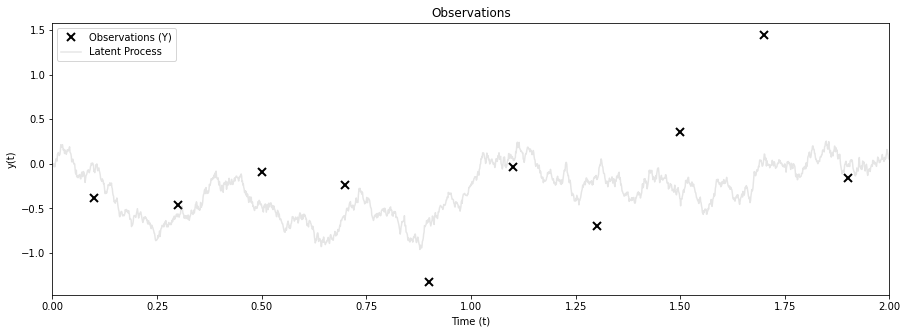

In [5]:
plot_data(obs_grid, obs_vals, time_grid, latent_p, t0, t1, "", None, None)

## Inference

In [6]:
obs_data = (obs_grid, tf.squeeze(obs_vals, axis=0))
DTYPE = default_float()

likelihood = Gaussian(noise_var)

true_q = q * tf.ones((1, 1), dtype=DTYPE)
prior_sde = PriorOUSDE(initial_val=-1*decay, q=true_q)
initial_cov = q / (2 * decay)  # Steady covariance

### SDE-SSM

In [8]:
t_vgp_trainer = tVGPTrainer(observation_data=obs_data, likelihood=likelihood, time_grid=time_grid,
                            prior_sde=prior_sde, data_sites_lr=1.)

ssm_elbo, ssm_prior_prior_vals, _ = t_vgp_trainer.run(update_prior=False)

2022-08-29 13:33:39.753692: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


t-VGP: Starting ELBO -12.646712509518363;
t-VGP: Updating sites...
t-VGP: ELBO = -10.856484620349327
t-VGP: ELBO = -10.856484620349327
t-VGP: Sites converged! Linearizing...
t-VGP: ELBO before linearization -10.856484620349327!!!
t-VGP: ELBO after linearization -10.856484620349327!!!
ELBO diff : 0.0 


t-VGP: Updating sites...
t-VGP: ELBO = -10.856484620349327
t-VGP: Sites converged! Linearizing...
t-VGP: ELBO before linearization -10.856484620349327!!!
t-VGP: ELBO after linearization -10.856484620349327!!!
ELBO diff : 0.0 


t-VGP: ELBO converged!
t-VGP: Converged!!!


In [9]:
t_vgp_trainer.tvgp_model.elbo()

<tf.Tensor: shape=(), dtype=float64, numpy=-42410.457367344476>

In [10]:
t_vgp_trainer.tvgp_model.classic_elbo()

<tf.Tensor: shape=(), dtype=float64, numpy=-10.856484620349327>

## VGP

In [12]:
vgp_model = VariationalMarkovGP(input_data=obs_data,
                                prior_sde=prior_sde, grid=time_grid, likelihood=likelihood,
                                lr=1., initial_state_lr=1.)

vgp_model.p_initial_cov = tf.cast(tf.reshape(initial_cov, vgp_model.p_initial_cov.shape), dtype=DTYPE)
vgp_model.q_initial_cov = tf.identity(vgp_model.p_initial_cov)
vgp_model.p_initial_mean = tf.zeros_like(vgp_model.p_initial_mean)
vgp_model.q_initial_mean = tf.identity(vgp_model.p_initial_mean)

vgp_model.A = decay + 0. * vgp_model.A

v_gp_elbo, v_gp_prior_vals, _ = vgp_model.run(update_prior=False)

VGP: Starting ELBO -12.646712536980976
VGP - q loop: ELBO -11.114338514336445
VGP - q loop: ELBO -10.961379964996809
VGP - q loop: ELBO -10.960140911316845
VGP: Breaking q loop as ELBO converged!!!
VGP - x0 loop: ELBO -10.866804182558027
VGP - x0 loop: ELBO -10.866804182558027
VGP - q loop: ELBO -10.866803934243993
VGP: Breaking q loop as ELBO converged!!!
VGP - x0 loop: ELBO -10.858521655144745
VGP - x0 loop: ELBO -10.858521655144745
VGP: ELBO converged!!!
VGP: Inference converged!!!


## ELBO

<Figure size 1080x360 with 0 Axes>

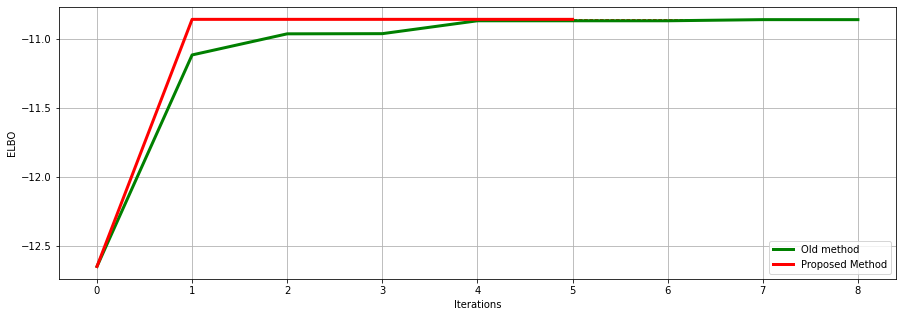

In [13]:
plt.clf()
fig, _ = plt.subplots(1, 1)

plt.plot(v_gp_elbo, label="Old method", color="green", linewidth=3.)
plt.plot(ssm_elbo, label="Proposed Method", color="red", linewidth=3.)
plt.hlines(ssm_elbo[-1], len(ssm_elbo)-1, len(v_gp_elbo)-1, color="red", linestyle="dashed", linewidth=1.)
plt.xlabel("Iterations")
plt.ylabel("ELBO")
plt.legend()
plt.yticks([-12.5, -12., -11.5, -11.0])
plt.grid(True)
tikzplotlib.save('elbo_iterations.tex', figure=fig)

plt.show()

## GPR

In [14]:
kernel = OrnsteinUhlenbeck(decay=decay, diffusion=q)

gpr_model = get_gpr(obs_data, kernel, train=False, noise_stddev=np.sqrt(noise_var))

print(-1 * gpr_model.loss())

tf.Tensor(-10.856236773077981, shape=(), dtype=float64)


## Plot ELBO bound

In [16]:
decay_value_range = np.linspace(0.01, decay + 5.5, 40)
ssm_elbo_vals = []
vgp_elbo_vals = []
gpr_elbo_vals = []
ssm_model = t_vgp_trainer.tvgp_model

for decay_val in decay_value_range:
    kernel = OrnsteinUhlenbeck(decay=decay_val, diffusion=q)
    gpr_model._kernel = kernel
    gpr_elbo_vals.append(gpr_model.log_likelihood().numpy().item())
    
    ssm_model.prior_sde = PriorOUSDE(-1*decay_val, q=true_q)
    # Steady covariance
    ssm_model.initial_chol_cov = tf.linalg.cholesky((q / (2 * decay_val)) + 0. * ssm_model.initial_chol_cov)
    ssm_model._linearize_prior()  # To linearize the new prior
    ssm_elbo_vals.append(ssm_model.classic_elbo())

    vgp_model.prior_sde = PriorOUSDE(-1*decay_val, q=true_q)
    # Steady covariance
    vgp_model.p_initial_cov = (q / (2 * decay_val)) + 0. * vgp_model.p_initial_cov
    vgp_elbo_vals.append(vgp_model.elbo())

## Plotting

<Figure size 1080x360 with 0 Axes>

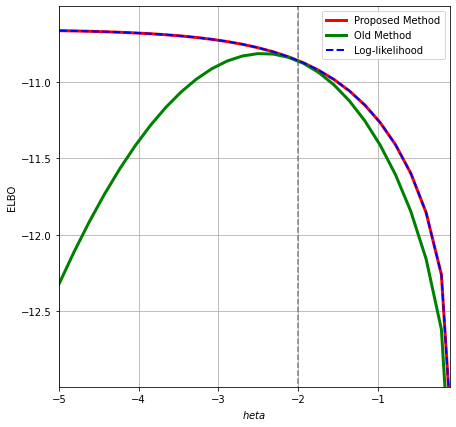

In [17]:
plt.clf()
fig, _  = plt.subplots(1, 1, figsize=(7, 7))
plt.plot(-1 * decay_value_range, ssm_elbo_vals, label="Proposed Method", linewidth=3.,
         color="red")

plt.plot(-1 * decay_value_range, vgp_elbo_vals, label="Old Method", linewidth=3., color="green")

plt.plot(-1 * decay_value_range, gpr_elbo_vals, label="Log-likelihood", linewidth=2., linestyle="dashed",
        color="blue")

plt.vlines(-1*decay, np.min(vgp_elbo_vals) - 0.5, np.max(ssm_elbo_vals) + 0.5, linestyle="dashed",
           color="gray")

plt.legend(loc='upper right')
plt.xlim(-5., -0.1)
plt.ylim(-13, -10.5)

plt.yticks([-12.5, -12., -11.5, -11.0])
plt.ylabel("ELBO")
plt.xlabel("$\theta$")
plt.grid(True)

tikzplotlib.save('elbo_bound.tex', figure=fig)

plt.show()